In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt, animation
import numpy as np
import itertools
import pandas as pd

In [2]:
def generate_random_city_graph(connection_prob=0.1, min_weight=1, max_weight=100):
    """
    Generate a random graph representing cities connected with weighted edges.

    Parameters:
    - num_cities (int): Number of cities (nodes) in the graph.
    - connection_prob (float): Probability of a connection (edge) between any two cities.
    - min_weight (int): Minimum weight (distance) for the edges.
    - max_weight (int): Maximum weight (distance) for the edges.

    Returns:
    - G (networkx.Graph): A NetworkX graph with cities as nodes and weighted edges.
    """
    num_cities = random.randint(5,10) # Generate just from 20 to 26 because I want only alphabet characters as nodes
    # Generate random city names (A, B, C, ...)
    city_names = [chr(65 + i) for i in range(num_cities)]

    # Create a graph
    G = nx.Graph()

    # Add cities as nodes
    G.add_nodes_from(city_names)

    # Randomly connect cities with random weights (distances)
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            weight = random.randint(min_weight, max_weight)  # Random distance
            G.add_edge(city_names[i], city_names[j], weight=weight)

    return G

In [3]:
# Example usage
random_graph = generate_random_city_graph()

In [4]:
def draw_graph(G):
    """
    Draw the generated graph with cities and weighted connections.

    Parameters:
    - G (networkx.Graph): The graph to be drawn.
    """
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)

    # Clear any previous plot
    plt.clf()
    
    # Draw the graph
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges})
    #nx.draw_networkx_edge(G, pos, with_labels=False)

    plt.title("Graph")
    plt.show()
    return pos

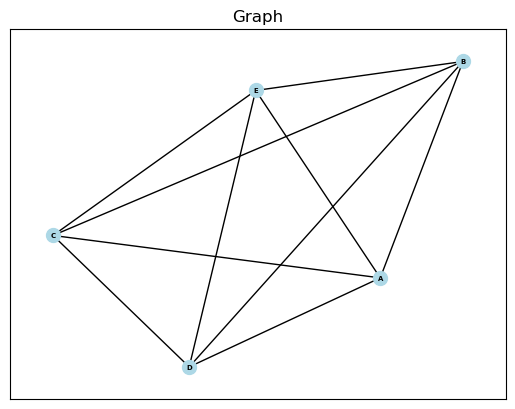

In [5]:
originalLayout = draw_graph(random_graph)

In [6]:
def generatePopulation(G, populationSize):
    populations = []
    nodes = list(G.nodes)
    for i in range(0, populationSize): 
        population = random.sample(nodes, len(nodes))
        population.append(population[0]) # append first element of array because he needs to end where he started
        populations.append(population)
    return populations
def evaluateAll(G, population):
    distances = []
    for solution in population:
        distance = evaluate(G, solution)
        distances.append(distance)
    return distances
def evaluate(G, x):
    # x represents a way which is gonna be list of all edges, first and last edge will be the same
    totalDistance = 0
    for i in range(0,len(x) - 1): # All edges except the last one because it doesnt go anywhere
        fromIndex = x[i]
        toIndex = x[i+1]
        totalDistance += G[fromIndex][toIndex]["weight"]
    return totalDistance
def crossover(x, y):
    #Need to make sure that x and y are lists, for some reason I started to get numpyarrays but not sure why
    x = list(x)
    y = list(y)
    #print(f"typ: {type(y)} content: {y}")
    j = random.randint(0, len(x) - 2) # -1 for bounds control of index and -1 because randint generation includes both of bounds numbers
    offspring = x[0:j+1]
    for i in range(j + 1, len(x) - 1): # Last member has to be same as first
        if y[i] not in offspring:
            offspring.append(y[i])
        else:
            for k in range(j,-1,-1): # We want to include even first element because the start and end is taken from first parent, not the second one
                if y[k] not in offspring:
                    offspring.append(y[k])
                    break
    offspring.append(offspring[0])
    #print(f"Velikost x: {len(x)} Velikost y: {len(y)} Velikost potomka: {len(offspring)}")
    return offspring
def mutate(x):
    randI = random.randint(1,len(x) - 2) # - 2 for index bounds and we dont want to swap last element
    randJ = random.randint(1,len(x) - 2)
    while randI == randJ: # Make sure we pick different indices
        randJ = random.randint(1, len(x) - 2)
    tmp = x[randI]
    x[randI] = x[randJ]
    x[randJ] = tmp
    return x
def GeneticAlgorithm(G):
    NP = 20
    gen = 200
    D = len(G.nodes)
    population = generatePopulation(G, NP)
    evaluationsPopulation = evaluateAll(G, population)
    for i in range(0,gen):
        new_population = np.copy(population)
        for j in range(0,NP):
            parent_A = population[j]
            listOfIndices = list(range(0,NP))
            listOfIndices.remove(j) # Possible indices withou j index to ensure we dont pick same index
            randomIndex = random.randint(0,NP - 2) # Go from 0 to NP - 2, because of bounds and one element is removed
            parent_B = population[randomIndex] # Random population
            offspring_AB = crossover(parent_A, parent_B)
            if np.random.uniform() < 0.5:
                offspring_AB = mutate(offspring_AB)
            offspringVal = evaluate(G, offspring_AB) #Evaluate offspring_AB
            if offspringVal < evaluationsPopulation[j]:
                #print(f"Index: {len(G.nodes)} new_population: {new_population[j]} new_population2: {new_population[randomIndex]} offspring: {offspring_AB}")
                new_population[j] = offspring_AB # Update population
                evaluationsPopulation[j] = offspringVal # Update distance for new population
        population = new_population
    return population
        

In [7]:
#evaluate(random_graph, list(random_graph.nodes))
populations = generatePopulation(random_graph, 5)

In [8]:
offspring = crossover(populations[0], populations[1])

In [9]:
len(random_graph.nodes)

5

In [10]:
print(f" p0: {populations[0]}\n p1: {populations[1]}\n of: {offspring}")

 p0: ['D', 'E', 'C', 'B', 'A', 'D']
 p1: ['D', 'A', 'C', 'B', 'E', 'D']
 of: ['D', 'E', 'C', 'B', 'A', 'D']


In [11]:
mutate(offspring)

['D', 'E', 'C', 'A', 'B', 'D']

In [12]:
result = GeneticAlgorithm(random_graph)

In [13]:
def pickShortestRoute(G, routes):
    minI = -1
    shortestPath = 40000
    evaluations = evaluateAll(G, routes)
    for i in range(0, len(evaluations)):
        if evaluations[i] < shortestPath:
            shortestPath = evaluations[i]
            minI = i
    return (routes[minI], evaluations[minI])

In [14]:
shortestRoute = pickShortestRoute(random_graph, result)

In [15]:
def constructPathGraph(G, path):
    subG = nx.Graph()

    subG.add_nodes_from(path)
    for i in range(0,len(path) - 1):
        fromIndex = path[i]
        toIndex = path[i+1]
        weight = G[fromIndex][toIndex]["weight"]
        subG.add_edge(path[i], path[i+1], weight=weight)
    return subG

In [16]:
result

array([['C', 'B', 'D', 'E', 'A', 'C'],
       ['C', 'B', 'D', 'E', 'A', 'C'],
       ['E', 'D', 'B', 'C', 'A', 'E'],
       ['B', 'C', 'A', 'E', 'D', 'B'],
       ['D', 'B', 'C', 'A', 'E', 'D'],
       ['B', 'C', 'A', 'E', 'D', 'B'],
       ['E', 'D', 'B', 'C', 'A', 'E'],
       ['D', 'B', 'C', 'A', 'E', 'D'],
       ['C', 'B', 'D', 'E', 'A', 'C'],
       ['E', 'D', 'B', 'C', 'A', 'E'],
       ['B', 'C', 'A', 'E', 'D', 'B'],
       ['C', 'A', 'E', 'D', 'B', 'C'],
       ['A', 'C', 'B', 'D', 'E', 'A'],
       ['D', 'E', 'A', 'C', 'B', 'D'],
       ['B', 'D', 'E', 'A', 'C', 'B'],
       ['A', 'C', 'B', 'D', 'E', 'A'],
       ['A', 'C', 'B', 'D', 'E', 'A'],
       ['C', 'B', 'D', 'E', 'A', 'C'],
       ['A', 'E', 'D', 'B', 'C', 'A'],
       ['E', 'D', 'B', 'C', 'A', 'E']], dtype='<U1')

In [17]:
distances = evaluateAll(random_graph, result)

In [18]:
dfPaths = pd.DataFrame(result)
dfPaths["distance"] = distances

In [19]:
dfPaths.sort_values("distance")

,0,1,2,3,4,5,distance
0,C,B,D,E,A,C,160
17,C,B,D,E,A,C,160
16,A,C,B,D,E,A,160
15,A,C,B,D,E,A,160
14,B,D,E,A,C,B,160
13,D,E,A,C,B,D,160
12,A,C,B,D,E,A,160
11,C,A,E,D,B,C,160
10,B,C,A,E,D,B,160
9,E,D,B,C,A,E,160


In [20]:
sorted_nodes = [x for _, x in sorted(zip(distances, result), key=lambda pair: pair[0],reverse=True)]

In [21]:
sorted_nodes_array = np.array(sorted_nodes)

In [22]:
sorted_nodes_array

array([['C', 'B', 'D', 'E', 'A', 'C'],
       ['C', 'B', 'D', 'E', 'A', 'C'],
       ['E', 'D', 'B', 'C', 'A', 'E'],
       ['B', 'C', 'A', 'E', 'D', 'B'],
       ['D', 'B', 'C', 'A', 'E', 'D'],
       ['B', 'C', 'A', 'E', 'D', 'B'],
       ['E', 'D', 'B', 'C', 'A', 'E'],
       ['D', 'B', 'C', 'A', 'E', 'D'],
       ['C', 'B', 'D', 'E', 'A', 'C'],
       ['E', 'D', 'B', 'C', 'A', 'E'],
       ['B', 'C', 'A', 'E', 'D', 'B'],
       ['C', 'A', 'E', 'D', 'B', 'C'],
       ['A', 'C', 'B', 'D', 'E', 'A'],
       ['D', 'E', 'A', 'C', 'B', 'D'],
       ['B', 'D', 'E', 'A', 'C', 'B'],
       ['A', 'C', 'B', 'D', 'E', 'A'],
       ['A', 'C', 'B', 'D', 'E', 'A'],
       ['C', 'B', 'D', 'E', 'A', 'C'],
       ['A', 'E', 'D', 'B', 'C', 'A'],
       ['E', 'D', 'B', 'C', 'A', 'E']], dtype='<U1')

In [48]:
shortestRoute[0]

array(['A', 'G', 'E', 'B', 'C', 'D', 'F', 'H', 'A'], dtype='<U1')

In [49]:
subG = constructPathGraph(random_graph, shortestRoute[0])

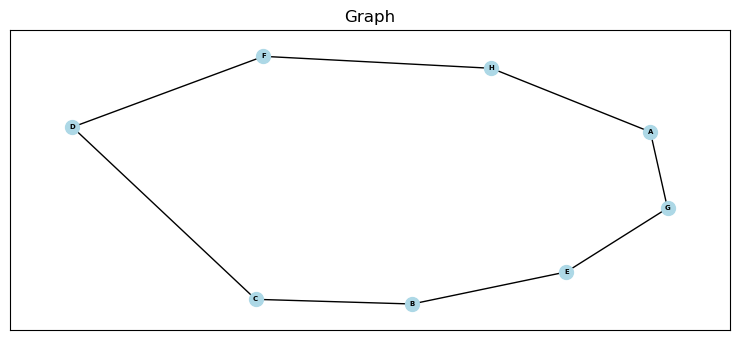

{'A': array([0.65138182, 0.38292456]),
 'G': array([ 0.70038887, -0.18439797]),
 'E': array([ 0.41119644, -0.6588336 ]),
 'B': array([-0.02940924, -0.89758173]),
 'C': array([-0.47651611, -0.86290593]),
 'D': array([-1.        ,  0.41873877]),
 'F': array([-0.45414353,  0.94548844]),
 'H': array([0.19710175, 0.85656746])}

In [50]:
draw_graph(subG)

In [51]:
list(subG.edges)

[('A', 'G'),
 ('A', 'H'),
 ('G', 'E'),
 ('E', 'B'),
 ('B', 'C'),
 ('C', 'D'),
 ('D', 'F'),
 ('F', 'H')]

In [52]:
def animatePathCreation(G, pos):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig = plt.figure(figsize=(10, 6))
    path = nx.Graph()
    path.add_nodes_from(G.nodes)
    connections = list(G.edges)
    #wrong order fix
    tmp = connections[1]
    connections.remove(tmp)
    connections.append(tmp)
    nx.draw_networkx(path, with_labels=True, pos = pos, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')

    def animate(i):
        fig.clear()
        path.add_edges_from([connections[i]])
        nx.draw_networkx(path, with_labels=True, pos = pos, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')

    ani = animation.FuncAnimation(fig, animate, frames=len(connections), interval=1000, repeat=True)
    ani.save("PathAnimation.gif")
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


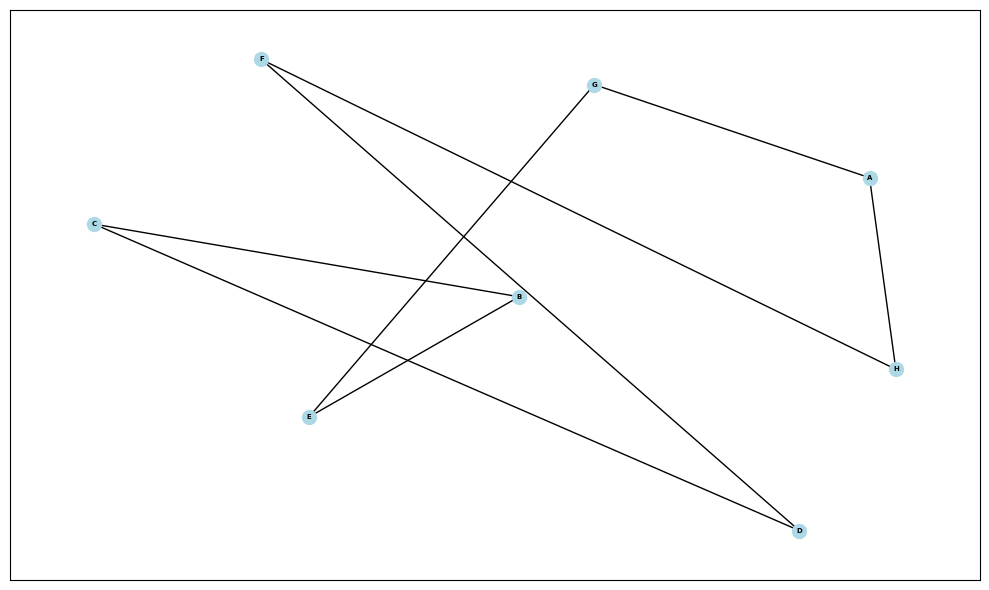

In [53]:
animatePathCreation(subG, originalLayout)

In [54]:
def animateTSM(G, paths, pos):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig = plt.figure(figsize=(10, 6))
    path = nx.Graph()
    path.add_nodes_from(G.nodes)
    nx.draw_networkx(path, with_labels=True, pos = pos, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')

    def animate(i):
        fig.clear()
        fig.suptitle("Index 0-19: " + str(i))
        constructedPath = constructPathGraph(G, paths[i])
        path.add_edges_from(list(constructedPath.edges))
        nx.draw_networkx(path, with_labels=True, pos = pos, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')
        path.remove_edges_from(list(constructedPath.edges))
        
    ani = animation.FuncAnimation(fig, animate, frames=len(paths), interval=1000, repeat=True)
    ani.save("TSMAnimation.gif")
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


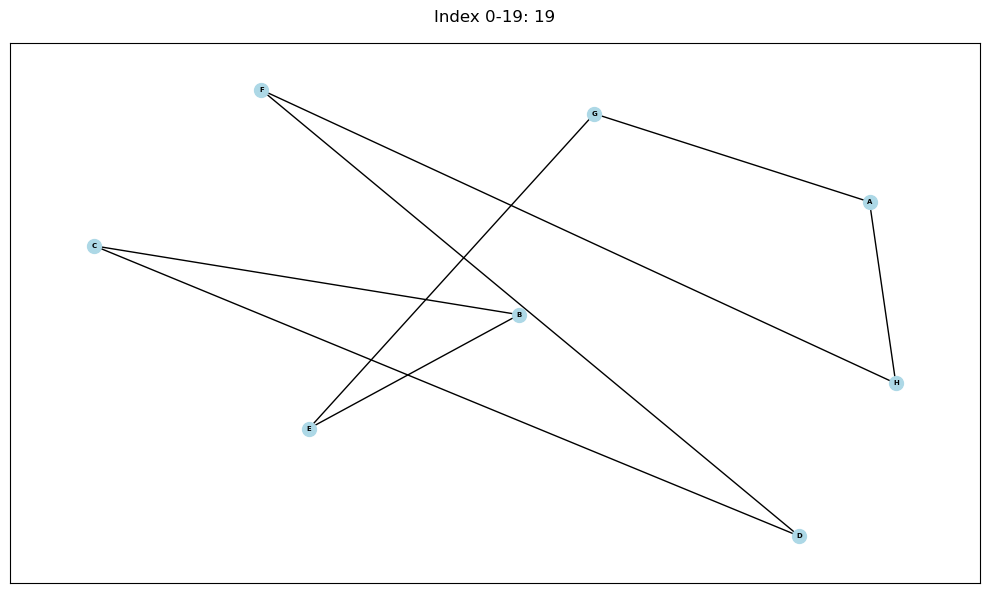

In [55]:
animateTSM(random_graph, sorted_nodes_array, originalLayout)